In [2]:
%pylab inline
import epi_prediction
import pandas as pd
import nibabel as nib 
from nilearn import image # for resampling of wm mask
from nilearn.plotting import plot_img,plot_glass_brain
import os


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 26 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 26 days
/home/nick/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Populating the interactive namespace from numpy and matplotlib


## Functions for stuff

In [35]:
def load_db(base_dir,classes):
    """ create a pandas DataFrame based on Parameters
    
    Parameters
    ----------
    base_dir : string
        directory structured with each folder representing mode and each mode folder 
        containing nifti volumes.
    classes : list of tuples
        tuple of form [(row label for Dataframe,file name Identifier)...].
    
    Returns
    ----------
    df : pandas.DataFrame
        DataFrame of shape (Classes,Modes) contain a list of file paths at each index.
    
    """
    dir_list = sorted(os.listdir(base_dir))
    df = pd.DataFrame(columns=[i[0] for i in classes],index = dir_list )
    for directory in dir_list:
        for c in classes:
            path = '{}{}{}'.format(base_dir,directory,'/')
            df.set_value(directory,c[0],[path + d for d in os.listdir(path) if c[1] in d])
    return df
def create_mask(wm,epi,threshold =.5):
    """Resample a brain mask to an epi
    
    Parameters
    ----------
    wm : nibabel.Nifti1Image 
        Mask as Nibabel Nifti1Image Object 
        
    epi : nibabel.Nifti1Image 
        EPI as Nibabel Nifti1Image Object
        
    threshold : float, between 0 and 1 (default=.5)
        Threshold at which to apply mask to epi
        
    Returns
    ----------
    mask : nibabel.Nifti1Image
        Resampled brain mask
    """
    mask = image.resample_img(wm,target_shape=epi.shape, target_affine=epi.get_affine())
    img = mask.get_data()
    img[img > threshold] = 1.
    img[img <= threshold] = 0.
    return nib.Nifti1Image(img,eye(4))

def apply_mask_to_epi(mask_path,epi_path,threshold=.5):
    """Apply a mask to an epi and return a numpy array of 1xN_VOXELS
    
    Parameters
    ----------
    mask_path : String
        file path of mask nifti volume
        
    epi_path : String
        file path of epi nifti volume
        
    threshold : float, between 0 and 1 (default=.5)
        Threshold at which to apply mask to epi
        
    Returns
    ----------
    masked_vol : numpy.ndarray
    an array of voxels corresponding to mask
    """
    mask_data = create_mask(nib.load(mask_path),nib.load(epi_path)).get_data()
    epi_data = nib.load(epi_path).get_data()
    mask_data = mask_data.reshape((-1,1))
    epi_data = epi_data.reshape((-1,1))
    return epi_data[mask_data == 1]
def list_mask_apply(l,mask_path,threshold=.5):
    """ helper function for mask_dataframe"""
    ret = []
    for vol in l:
        ret.append(apply_mask_to_epi(mask_path,vol,threshold))
    return ret

def mask_dataframe(df,mask_path,threshold=.5):
    """Apply a mask to an epi and return a numpy array of 1xN_VOXELS
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame object to mask
  
    mask_path : string
        file path of mask nifti volume

    threshold : float, between 0 and 1 (default=.5)
        Threshold at which to apply mask to epi
        
    Returns
    ----------
    df : pandas.DataFrame
        Dataframe with lists of file names changed to lists of masked ndarrays
    """
    for mode, i in df.iterrows():
        for i,l in enumerate(df.ix[mode]):
            df.ix[mode][i] = list_mask_apply(l,mask_path,threshold)
    return df


# MAKE SURE THIS IS RIGHT

def df_scores(grid_search,gamma_range,C_range):    
    """Create a dataframe of scores of params
    
    Parameters
    ----------
    grid_search : sklearn.grid_search.GridSearchCV
        grid search object after it has been fit
  
    gamma_range : numpy.ndarray
        range of gamma values used to fit grid
        
    C_range : numpy.ndarray
        range of C values used to fit grid
        
    Returns
    ----------
    df : pandas.DataFrame
        labeled dataframe showing scores 
        
    scores : numpy.ndarray
        array of scores
    """
    scores = np.array([x[1] for x in grid_search.grid_scores_]).reshape(len(C_range), len(gamma_range))
    return pd.DataFrame(scores,index=C_range,columns=gamma_range)



def plot_scores(grid_search,gamma_range,C_range):
    """Plot scores with matploblib imshow from a grid search
    
    Parameters
    ----------
    grid_search : sklearn.grid_search.GridSearchCV
        grid search object after it has been fit
  
    gamma_range : numpy.ndarray
        range of gamma values used to fit grid
    C_range : numpy.ndarray
        range of C values used to fit grid
        
    """
    plt.figure(figsize=(15,10))
    scores = np.array([x[1] for x in grid_search.grid_scores_]).reshape(len(C_range), len(gamma_range))
    cax = plt.imshow(scores, interpolation="nearest", cmap=plt.cm.cool)
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.xlabel('$\gamma$')
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.ylabel('C')
    plt.title('Validation accuracy')
    cbar = plt.colorbar(cax, ticks=[np.min(scores), np.mean(scores), np.max(scores)])
    plt.show()
    print 'Max Performance : {}'.format((np.round(np.max(scores),5)))
    

In [4]:
## PARAMS ##

base_dir = '/mnt/DKI_STUFF/modalities/'
classes = [('cons','CON'),('pats','PAT')]
mask_path = '/mnt/DKI_STUFF/code/masks/white.nii'

###########

# Mask visualization

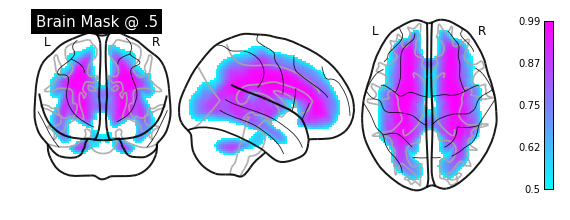

In [19]:
plot_glass_brain(nib.load(mask_path),
                 threshold=.5,
                 colorbar=True,
                 title='Brain Mask @ .5',
                 cmap=plt.cm.cool,alpha=.9
                )
plt.show()

In [6]:
# grabbing dmean and fa for testing 
dfa = load_db(base_dir,classes)

epi_paths = dfa[1:4:2]
epi_paths

cons  \
dmean  [/mnt/DKI_STUFF/modalities/dmean/dmeanCON043.n...   
fa     [/mnt/DKI_STUFF/modalities/fa/faCON034.nii, /m...   

                                                    pats  
dmean  [/mnt/DKI_STUFF/modalities/dmean/dmeanPAT078.n...  
fa     [/mnt/DKI_STUFF/modalities/fa/faPAT100.nii, /m...

In [7]:
## applying mask to matrices
masked_matrices = mask_dataframe(epi_paths,mask_path)

masked_matrices

cons  \
dmean  [[0.900367, 0.929843, 0.892926, 0.920383, 0.87...   
fa     [[0.193831, 0.233026, 0.21176, 0.266958, 0.191...   

                                                    pats  
dmean  [[0.947932, 0.997482, 0.966199, 0.994236, 0.93...  
fa     [[0.159587, 0.201227, 0.169772, 0.196879, 0.16...

# $We\;want\;to\;run\;D_{mean}\;,K_{mean}\&\;F_{a}$

# just running dmean atm

In [8]:
# creating SUBJECTxFEATURE matrix
dmean = vstack((masked_matrices.ix['dmean'].cons,masked_matrices.ix['dmean'].pats))

# creating y output vector (this is ugly fix this) (yyy must have shape of (trn_exmpl,-))
y_len = map(len,masked_matrices.ix['dmean'])
n_samples = sum(y_len)
yyy = np.vstack((np.array([0] * y_len[0]).reshape((-1,1)),np.array([1] * y_len[1]).reshape((-1,1)))).reshape(n_samples)

##Initialize SVC PIPELINE

In [9]:
from nilearn.input_data import NiftiMasker
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut
from sklearn.svm import LinearSVC

##Grid Search for Best Parameters of $\gamma$ and C
* Note : problem with verbosity when multithreading ; no output, but it is running.

* TODO:
 * Figure out if we can use feature selection api to do l1 and l2 regularization
   * is the built in regularization param in the SVM sufficient?
   * SVM.LinearSVR :
   * penalty : string, ‘l1’ or ‘l2’ (default=’l2’) Specifies the norm used in the penalization. The ‘l2’ penalty is the standard used in SVC. The ‘l1’ leads to  coef_ vectors that are sparse.
  
 * iterate through all methods

In [29]:
## PIPELINE PARAMS ####
C_range = np.logspace(-2, 10, 8)
C_range = np.array([1,5,10,11,15])
gamma_range = np.logspace(-3, 1, 10)
lambda_range = [.1,1,10]
rho_range = [.1,1,10]



n_cpus = 7
verbosity = 200

#######################
print 'gamma_range : \n{}'.format(gamma_range)
print '\nC_range : \n{}'.format(C_range)
print '{} total runs...'.format(len(C_range)*len(gamma_range))

gamma_range : 
[  1.00000000e-03   2.78255940e-03   7.74263683e-03   2.15443469e-02
   5.99484250e-02   1.66810054e-01   4.64158883e-01   1.29154967e+00
   3.59381366e+00   1.00000000e+01]

C_range : 
[ 1  5 10 11 15]
50 total runs...


#$K\;Best\;Feature\;Selection\;@\;K=500$

In [30]:
## creating sklearn pipeline object
feature_selection_svc = Pipeline([
        ('feature_selection', SelectKBest(k=500)), 
        ('svc', SVC())
    ])


## creating param_grid for search
param_grid = dict(svc__gamma=gamma_range, 
                  svc__C=C_range
                 )
## cross-val function
cv = LeaveOneOut(n_samples)



grid = GridSearchCV(feature_selection_svc, param_grid=param_grid,cv=cv,verbose=verbosity,n_jobs=n_cpus)
grid.fit(dmean,yyy)

Fitting 68 folds for each of 50 candidates, totalling 3400 fits
Memmaping (shape=(68, 435702), dtype=float32) to new file /dev/shm/joblib_memmaping_pool_10425_139852850079312/10425-139852846787792-139852903655504-0.pkl
Pickling array (shape=(68,), dtype=int64).
Pickling array (shape=(67,), dtype=int64).
Pickling array (shape=(1,), dtype=int64).
Memmaping (shape=(68, 435702), dtype=float32) to old file /dev/shm/joblib_memmaping_pool_10425_139852850079312/10425-139852846787792-139852903655504-0.pkl
Pickling array (shape=(68,), dtype=int64).
Pickling array (shape=(67,), dtype=int64).
Pickling array (shape=(1,), dtype=int64).
Memmaping (shape=(68, 435702), dtype=float32) to old file /dev/shm/joblib_memmaping_pool_10425_139852850079312/10425-139852846787792-139852903655504-0.pkl
Pickling array (shape=(68,), dtype=int64).
Pickling array (shape=(67,), dtype=int64).
Pickling array (shape=(1,), dtype=int64).
Memmaping (shape=(68, 435702), dtype=float32) to old file /dev/shm/joblib_memmaping_poo

GridSearchCV(cv=sklearn.cross_validation.LeaveOneOut(n=68),
       estimator=Pipeline(steps=[('feature_selection', SelectKBest(k=500, score_func=<function f_classif at 0x7f320e720de8>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=7,
       param_grid={'svc__gamma': array([  1.00000e-03,   2.78256e-03,   7.74264e-03,   2.15443e-02,
         5.99484e-02,   1.66810e-01,   4.64159e-01,   1.29155e+00,
         3.59381e+00,   1.00000e+01]), 'svc__C': array([ 1,  5, 10, 11, 15])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=200)

[CV] .. svc__gamma=0.00774263682681, svc__C=1, score=1.000000 -   3.1s[CV] .. svc__gamma=0.00774263682681, svc__C=1, score=1.000000 -   2.3s[CV] .. svc__gamma=0.00774263682681, svc__C=1, score=1.000000 -   2.4s[CV] .. svc__gamma=0.00774263682681, svc__C=1, score=1.000000 -   2.3s[CV] .. svc__gamma=0.00774263682681, svc__C=1, score=0.000000 -   2.5s[CV] .. svc__gamma=0.00774263682681, svc__C=1, score=0.000000 -   3.3s






[CV] svc__gamma=0.00774263682681, svc__C=1 ...........................
[CV] svc__gamma=0.00774263682681, svc__C=1 ...........................
[CV] svc__gamma=0.00774263682681, svc__C=1 ...........................
[CV] svc__gamma=0.00774263682681, svc__C=1 ...........................
[CV] svc__gamma=0.00774263682681, svc__C=1 ...........................
[CV] svc__gamma=0.00774263682681, svc__C=1 ...........................
[CV] svc__gamma=0.00774263682681, svc__C=1 ...........................
[CV] .. svc__gamma=0.00774263682681, svc__C=1, score=1.000000 -   2.4s[CV] .

In [31]:
df_scores(grid,gamma_range,C_range)

0.001000   0.002783   0.007743   0.021544   0.059948   0.166810   \
1    0.544118   0.661765   0.720588   0.764706   0.764706   0.750000   
5    0.705882   0.764706   0.794118   0.794118   0.750000   0.705882   
10   0.735294   0.794118   0.794118   0.750000   0.720588   0.705882   
11   0.735294   0.794118   0.794118   0.750000   0.705882   0.705882   
15   0.764706   0.794118   0.794118   0.779412   0.705882   0.705882   

    0.464159   1.291550   3.593814   10.000000  
1    0.691176   0.514706   0.529412   0.529412  
5    0.676471   0.485294   0.529412   0.529412  
10   0.676471   0.485294   0.529412   0.529412  
11   0.676471   0.485294   0.529412   0.529412  
15   0.676471   0.485294   0.529412   0.529412

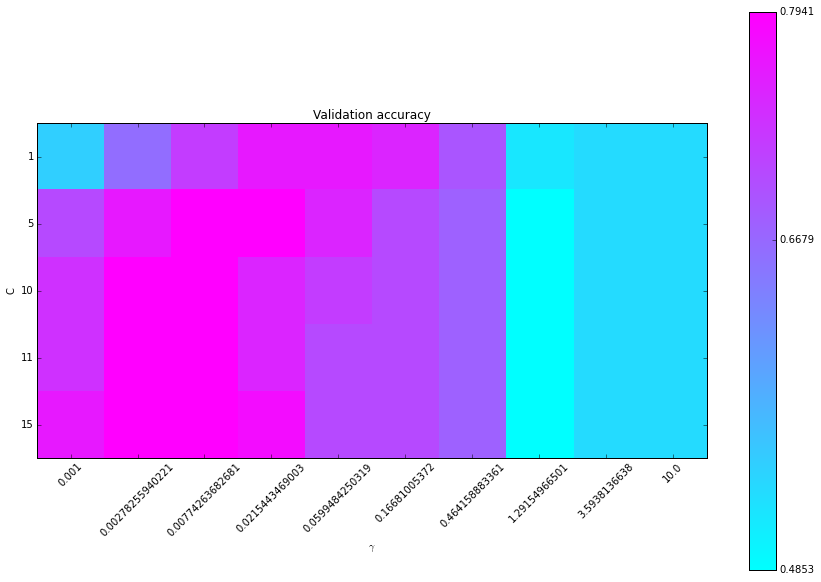

Max Performance : 0.79412


In [36]:
plot_scores(grid,gamma_range,C_range)

# $L_1\;Regularization\;(Lasso)$

* Note : had to set dual = False ;
 * dual : bool, (default=True) : Select the algorithm to either solve the dual or primal optimization problem. Prefer dual=False when n_samples > n_features.
 
 
 
 $L_1\alpha=\lambda\;???$
 
 $L_1\alpha=\rho\;???$
 
 Could also try LinearSVC__C



<a href=http://scikit-learn.org/stable/modules/feature_selection.html>"Feature Selection as part of pipeline" </a>

In [37]:
## creating sklearn pipeline object
feature_selection_svc = Pipeline([
        ('feature_selection', LinearSVC(penalty="l1",dual=False)),
        ('svc', SVC())
    ])


## creating param_grid for search
param_grid = dict(svc__gamma=gamma_range, 
                  svc__C=C_range,
               # feature_selection__alpha=lambda_range
                 )
                  
## cross-val function
cv = LeaveOneOut(n_samples)



grid = GridSearchCV(feature_selection_svc, param_grid=param_grid,cv=cv,verbose=verbosity,n_jobs=n_cpus)
grid.fit(dmean,yyy)

Fitting 68 folds for each of 50 candidates, totalling 3400 fits
Memmaping (shape=(68, 435702), dtype=float32) to new file /dev/shm/joblib_memmaping_pool_10425_139852847070736/10425-139852847266512-139852903655504-0.pkl
Pickling array (shape=(68,), dtype=int64).
Pickling array (shape=(67,), dtype=int64).
Pickling array (shape=(1,), dtype=int64).
Memmaping (shape=(68, 435702), dtype=float32) to old file /dev/shm/joblib_memmaping_pool_10425_139852847070736/10425-139852847266512-139852903655504-0.pkl
Pickling array (shape=(68,), dtype=int64).
Pickling array (shape=(67,), dtype=int64).
Pickling array (shape=(1,), dtype=int64).
Memmaping (shape=(68, 435702), dtype=float32) to old file /dev/shm/joblib_memmaping_pool_10425_139852847070736/10425-139852847266512-139852903655504-0.pkl
Pickling array (shape=(68,), dtype=int64).
Pickling array (shape=(67,), dtype=int64).
Pickling array (shape=(1,), dtype=int64).
Memmaping (shape=(68, 435702), dtype=float32) to old file /dev/shm/joblib_memmaping_poo

GridSearchCV(cv=sklearn.cross_validation.LeaveOneOut(n=68),
       estimator=Pipeline(steps=[('feature_selection', LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l1',
     random_state=None, tol=0.0001, verbose=0)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=7,
       param_grid={'svc__gamma': array([  1.00000e-03,   2.78256e-03,   7.74264e-03,   2.15443e-02,
         5.99484e-02,   1.66810e-01,   4.64159e-01,   1.29155e+00,
         3.59381e+00,   1.00000e+01]), 'svc__C': array([ 1,  5, 10, 11, 15])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=200)

[CV] .. svc__gamma=0.00774263682681, svc__C=1, score=1.000000 -   6.0s[CV] .. svc__gamma=0.00774263682681, svc__C=1, score=1.000000 -   5.8s[CV] .. svc__gamma=0.00774263682681, svc__C=1, score=1.000000 -   6.0s[CV] svc__gamma=0.00774263682681, svc__C=1 ...........................
[CV] svc__gamma=0.00774263682681, svc__C=1 ...........................
[CV] svc__gamma=0.00774263682681, svc__C=1 ...........................




[CV] .. svc__gamma=0.00774263682681, svc__C=1, score=1.000000 -   6.0s[CV] .. svc__gamma=0.00774263682681, svc__C=1, score=1.000000 -   5.9s[CV] .. svc__gamma=0.00774263682681, svc__C=1, score=1.000000 -   5.9s[CV] svc__gamma=0.00774263682681, svc__C=1 ...........................
[CV] svc__gamma=0.00774263682681, svc__C=1 ...........................
[CV] svc__gamma=0.00774263682681, svc__C=1 ...........................
[CV] svc__gamma=0.00774263682681, svc__C=1 ...........................



[CV] .. svc__gamma=0.00774263682681, svc__C=1, score=1.000000 -   5.7s[CV] .

In [38]:
df_scores(grid,gamma_range,C_range)

0.001000   0.002783   0.007743   0.021544   0.059948   0.166810   \
1    0.617647   0.720588   0.661765   0.647059   0.617647   0.602941   
5    0.676471   0.647059   0.573529   0.544118   0.558824   0.647059   
10   0.661765   0.617647   0.529412   0.544118   0.558824   0.661765   
11   0.661765   0.573529   0.558824   0.544118   0.573529   0.632353   
15   0.632353   0.544118   0.558824   0.558824   0.573529   0.661765   

    0.464159   1.291550   3.593814   10.000000  
1    0.500000   0.529412   0.529412   0.529412  
5    0.485294   0.529412   0.529412   0.529412  
10   0.500000   0.529412   0.529412   0.529412  
11   0.485294   0.529412   0.529412   0.529412  
15   0.500000   0.529412   0.529412   0.529412

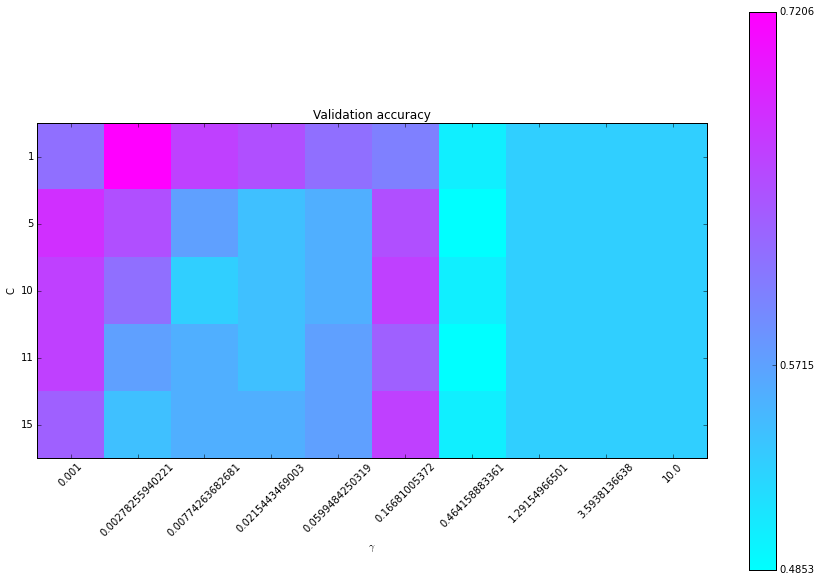

Max Performance : 0.72059


In [39]:
plot_scores(grid,gamma_range,C_range)

# $L_2\;Regularization\;(Ridge)$ 
 * This is really really slow, I think because it is less sparse

In [41]:
## creating sklearn pipeline object
feature_selection_svc = Pipeline([
        ('feature_selection', LinearSVC(penalty="l2")),
        ('svc', SVC())
    ])


gamma_range= np.array([.01])
C_range =[1]

## creating param_grid for search
param_grid = dict(svc__gamma=gamma_range,
                  svc__C=C_range
                 # feature_selection__alpha=rho_range
                 )
## cross-val function
cv = LeaveOneOut(n_samples)



grid = GridSearchCV(feature_selection_svc, param_grid=param_grid,cv=cv,verbose=verbosity,n_jobs=7)
grid.fit(dmean,yyy)

Fitting 68 folds for each of 1 candidates, totalling 68 fits
Memmaping (shape=(68, 435702), dtype=float32) to new file /dev/shm/joblib_memmaping_pool_10425_139852847748112/10425-139852846938832-139852903655504-0.pkl
Pickling array (shape=(68,), dtype=int64).
Pickling array (shape=(67,), dtype=int64).
Pickling array (shape=(1,), dtype=int64).
Memmaping (shape=(68, 435702), dtype=float32) to old file /dev/shm/joblib_memmaping_pool_10425_139852847748112/10425-139852846938832-139852903655504-0.pkl
Pickling array (shape=(68,), dtype=int64).
Pickling array (shape=(67,), dtype=int64).
Pickling array (shape=(1,), dtype=int64).
Memmaping (shape=(68, 435702), dtype=float32) to old file /dev/shm/joblib_memmaping_pool_10425_139852847748112/10425-139852846938832-139852903655504-0.pkl
Pickling array (shape=(68,), dtype=int64).
Pickling array (shape=(67,), dtype=int64).
Pickling array (shape=(1,), dtype=int64).
Memmaping (shape=(68, 435702), dtype=float32) to old file /dev/shm/joblib_memmaping_pool_1

GridSearchCV(cv=sklearn.cross_validation.LeaveOneOut(n=68),
       estimator=Pipeline(steps=[('feature_selection', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='l2', multi_class='ovr', penalty='l2',
     random_state=None, tol=0.0001, verbose=0)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=7,
       param_grid={'svc__gamma': array([ 0.01]), 'svc__C': [1]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=200)

In [42]:
df_scores(grid,gamma_range,C_range)

0.01
1  0.529412

ValueError: math domain error

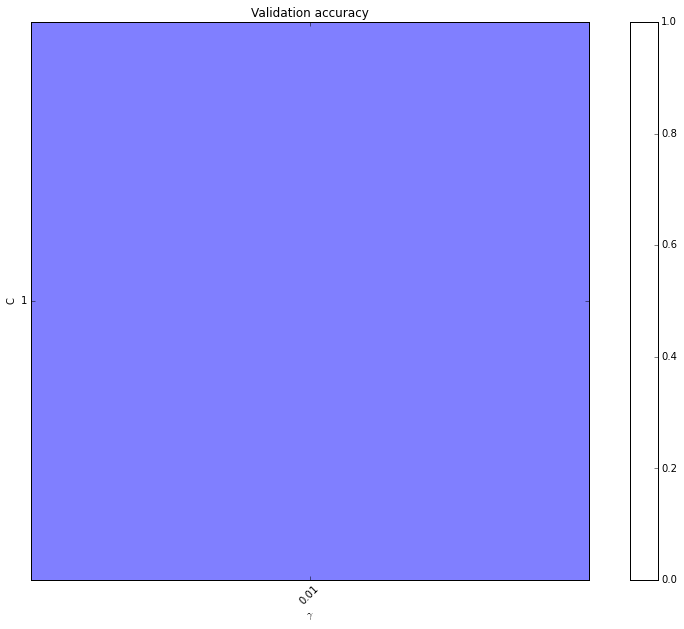

In [43]:
plot_scores(grid,gamma_range,C_range)

# $L_1\;\&\;L_2\;Regularization\;(Elastic Net)$
* Q : Does order matter? Is seperate like this ok?

In [ ]:
## creating sklearn pipeline object
feature_selection_svc = Pipeline([
        ('feature_selection_1', LinearSVC(penalty="l1",dual=False)),
        ('feature_selection_2', LinearSVC(penalty="l2")),
        ('svc', SVC())
    ])


## creating param_grid for search
param_grid = dict(svc__gamma=gamma_range, 
                  svc__C=C_range,
#                   feature_selection1__alpha = lambda_range,
#                   feature_selection2__alpha = rho_range
                 )
## cross-val function
cv = LeaveOneOut(n_samples)



grid = GridSearchCV(feature_selection_svc, param_grid=param_grid,cv=cv,verbose=verbosity,n_jobs=n_cpus)
grid.fit(dmean,yyy)

In [ ]:
# MAKE SURE THIS IS RIGHT
scores = np.array([x[1] for x in grid.grid_scores_]).reshape(len(C_range), len(gamma_range))
pd.DataFrame(scores,index=C_range,columns=gamma_range)

In [ ]:
cax = plt.imshow(scores, interpolation="nearest", cmap=plt.cm.hot)
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.xlabel('gamma')
plt.yticks(np.arange(len(C_range)), C_range)
plt.ylabel('C')
plt.title('Validation accuracy')
cbar = plt.colorbar(cax, ticks=[np.min(scores), np.mean(scores), np.max(scores)])
plt.show()
print 'Max Performance : {}'.format((np.round(np.max(scores),5)))

# Here, C & $\gamma$ are found through cv

In [23]:
anovas_450 = FeatureUnion([ (m, new_anova(m, k=150)) for m in index_map])
feature_selection_svc_450 = Pipeline([('feature_selection', anovas_450), ('svc', SVC())])
grid_450 = GridSearchCV(feature_selection_svc_450, param_grid=param_grid, cv=cv, scoring = scorer)
from sklearn.grid_search import RandomizedSearchCV
random_450 = RandomizedSearchCV(feature_selection_svc_450, param_distributions=param_grid, cv=cv, scoring = scorer)
random_450.fit(mat, labels)

In [26]:
random_450.grid_scores_

[mean: 0.00000, std: 0.00000, params: {'svc__gamma': 10.0, 'svc__C': 10000000000.0},
 mean: 0.00000, std: 0.00000, params: {'svc__gamma': 1.0000000000000001e-05, 'svc__C': 10.0},
 mean: 0.43336, std: 0.21426, params: {'svc__gamma': 0.001, 'svc__C': 1.0},
 mean: 0.00000, std: 0.00000, params: {'svc__gamma': 1.0, 'svc__C': 10000000.0},
 mean: 0.69697, std: 0.14559, params: {'svc__gamma': 1.0000000000000001e-05, 'svc__C': 1000000.0},
 mean: 0.00000, std: 0.00000, params: {'svc__gamma': 100.0, 'svc__C': 100000000.0},
 mean: 0.74412, std: 0.14642, params: {'svc__gamma': 1e-08, 'svc__C': 10000000000.0},
 mean: 0.69621, std: 0.18814, params: {'svc__gamma': 1.0000000000000001e-09, 'svc__C': 10000000.0},
 mean: 0.43336, std: 0.21426, params: {'svc__gamma': 0.0001, 'svc__C': 10.0},
 mean: 0.00000, std: 0.00000, params: {'svc__gamma': 1e-08, 'svc__C': 1000.0}]

##Explore if Principle Component Analysis can Better Select Features

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(mat, labels)
pca.explained_variance_ratio_

PCA(copy=True, n_components=20, whiten=False)

In [29]:
np.sum(pca.explained_variance_ratio_)

array([ 0.21797068,  0.08451933,  0.04719787,  0.03515985,  0.03011981,
        0.0236962 ,  0.02220851,  0.02181247,  0.01787787,  0.01699752,
        0.01645817,  0.01575456,  0.01452591,  0.01401594,  0.0135983 ,
        0.01271394,  0.01239047,  0.01220256,  0.01198456,  0.01153273], dtype=float32)

__Each new dimension still capturing variance, increase a little more__

In [31]:
pca = PCA(n_components=100)
pca.fit(mat, labels)
pca.explained_variance_ratio_

/usr/local/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


PCA(copy=True, n_components=100, whiten=False)

In [33]:
np.sum(pca.explained_variance_ratio_)

0.99999988

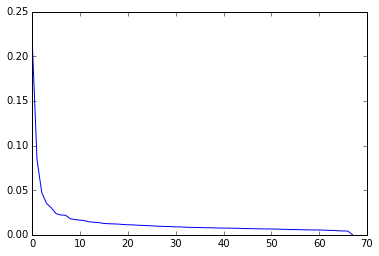

In [34]:
import matplotlib.pyplot as plt
plt.plot(pca.explained_variance_ratio_)
plt.show()

In [35]:
np.sum(pca.explained_variance_ratio_[:65])

0.99149513

_We Are Able to Capture Almost all variance with 65 dimensions, we may use this later._

##Calculate Confusion Matrix

In [36]:
labels_arr = np.array(labels)

feature_selection_svc.set_params(svc__C=C, svc__gamma=gamma)

cv_info, cv_info_train = epi_prediction.verbose_cv(mat, 
                                                   labels_arr, 
                                                   feature_selection_svc,
                                                   n_folds=n_folds,
                                                   verbose=False)

####
####
####
####
####
####


In [37]:
cv_info.avg_f1_score()

0.71293706293706294

In [38]:
cv_info.confusion_matrix()

array([[28,  8],
       [ 9, 23]])

In [39]:
cv_info.normalized_confusion_matrix()

array([[ 0.77777778,  0.22222222],
       [ 0.28125   ,  0.71875   ]])

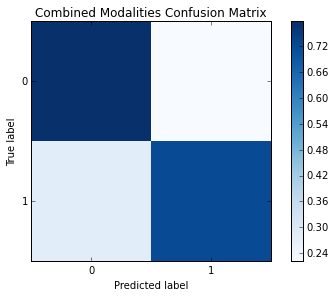

In [40]:
epi_prediction.plot_confusion_matrix(cv_info.normalized_confusion_matrix(), 
                      title="Combined Modalities Confusion Matrix")

##Try Just Best 500 instead of 1500

In [41]:
k = 500
feature_selection = SelectKBest(f_classif, k=k)
svc = SVC()
anova_500_svc = Pipeline([('anova', feature_selection), ('svc', svc)])

In [42]:
scorer = epi_prediction.verbose_scorer(total_runs)
grid_wmatter_500 = GridSearchCV(anova_500_svc, 
                            param_grid=param_grid, 
                            cv=cv, scoring = scorer)

grid_wmatter_500.fit(mat, labels)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 0 0], n_folds=6, shuffle=False, random_state=None),
       error_score='raise',
       estimator=Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7ff692727230>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'svc__gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'svc__C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
   

In [43]:
scores = [x[1] for x in grid_wmatter_500.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))
scores

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.67491087,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.67491087,  0.69353832,  0.70309821,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.67491087,  0.70637255,  0.68888146,  0.70309821,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.67491087,  0.69166667,  0.67818627,  0.68888146,  0.70309821,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.      

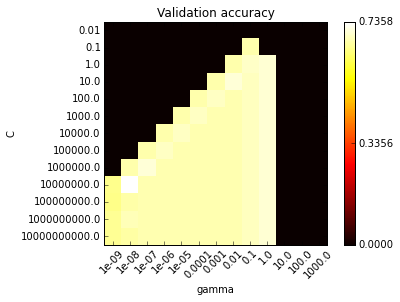

In [44]:
cax = plt.imshow(scores, interpolation="nearest", cmap=plt.cm.hot)
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.xlabel('gamma')
plt.yticks(np.arange(len(C_range)), C_range)
plt.ylabel('C')
plt.title('Validation accuracy')

cbar = plt.colorbar(cax, ticks=[np.min(scores), np.mean(scores), np.max(scores)])

plt.show()

In [45]:
C = C_range[8]
gamma = gamma_range[1]
scores[8][1]

0.67491087344028511

In [46]:
reload(epi_prediction)

<module 'epi_prediction' from 'epi_prediction.pyc'>

In [47]:
white_matter = epi_prediction.SimpleMasker('masks/white.nii', .2)

##Unsatisfactory Results, need new way to combine

__Will Try Combining Probalities from the SVM Outputs__

_Know the Best Params for Each SVM from other experiments_

In [48]:
svc_params_map = dict(dmean=dict(C=.01),
                      kmean=dict(C=1),
                      fa=dict(C=.1))

In [49]:
def new_anova_and_svc(mod, k=500): 
    svc = SVC()
    svc.kernel='linear'
    svc.C = svc_params_map[mod]['C']
    svc.probability=True
    return Pipeline([
        ('columns', epi_prediction.ColumnSelector(index_map[mod])),
        ('anova', SelectKBest(k=k)),
        ('svc', svc)
    ])
    
svcs = [new_anova_and_svc(m) for m in index_map]

In [50]:
combined_alg = epi_prediction.ProbableBinaryEnsembleAlg(svcs)

In [51]:
cv_combos, cv_combos_train = epi_prediction.verbose_cv(mat, labels_arr, combined_alg, n_folds=6, verbose=False)

####
####
####
####
####
####


In [52]:
reload(epi_prediction)

<module 'epi_prediction' from 'epi_prediction.pyc'>

In [53]:
cv_combos.avg_f1_score()

0.74020979020979016

In [54]:
cv_combos.normalized_confusion_matrix()

array([[ 0.80555556,  0.19444444],
       [ 0.25      ,  0.75      ]])

In [55]:
cv_combos.f1_scores()

[0.92307692307692302,
 0.59999999999999998,
 0.90909090909090906,
 0.59999999999999998,
 0.5,
 0.90909090909090906]

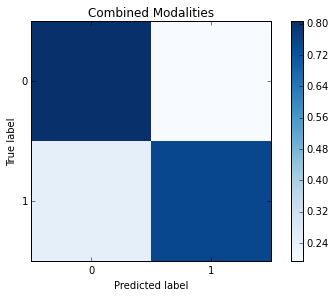

In [56]:
epi_prediction.plot_confusion_matrix(cv_combos.normalized_confusion_matrix(), "Combined Modalities")

##Good Results, Lets Compare With Removing Modalities

In [57]:
[m for m in index_map]

['fa', 'dmean', 'kmean']

In [58]:
svcs_no_kmean = [new_anova_and_svc(m) for m in ['fa', 'dmean']]

In [59]:
combined_alg_no_kmean = epi_prediction.ProbableBinaryEnsembleAlg(svcs_no_kmean)
cv_combos_no_kmean, cv_combos_train_no_kmean = epi_prediction.verbose_cv(mat, 
                                                                         labels_arr, 
                                                                         combined_alg_no_kmean,
                                                                         n_folds=6, 
                                                                         verbose=False)

####
####
####
####
####
####


In [60]:
cv_combos_no_kmean.avg_f1_score()

0.67520257520257509

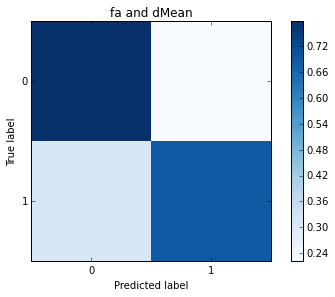

In [61]:
epi_prediction.plot_confusion_matrix(cv_combos_no_kmean.normalized_confusion_matrix(), "fa and dMean")

In [62]:
cv_combos_no_kmean.normalized_confusion_matrix()

array([[ 0.77777778,  0.22222222],
       [ 0.3125    ,  0.6875    ]])

_kMean is a major contributor, next examine contribution from other 2_

In [63]:
svcs_no_fa = [new_anova_and_svc(m) for m in ['kmean', 'dmean']]
combined_alg_no_fa = epi_prediction.ProbableBinaryEnsembleAlg(svcs_no_fa)
cv_combos_no_fa, cv_combos_train_no_fa = epi_prediction.verbose_cv(mat, 
                                                                   labels_arr, 
                                                                   combined_alg_no_fa,
                                                                   n_folds=6, 
                                                                   verbose=False)

####
####
####
####
####
####


In [64]:
cv_combos_no_fa.avg_f1_score()

0.70449550449550447

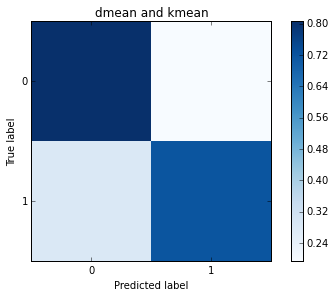

In [65]:
epi_prediction.plot_confusion_matrix(cv_combos_no_fa.normalized_confusion_matrix(), "dmean and kmean")

In [66]:
cv_combos_no_fa.normalized_confusion_matrix()

array([[ 0.80555556,  0.19444444],
       [ 0.28125   ,  0.71875   ]])

_let's try one more time with no dmean_

In [67]:
svcs_no_dmean = [new_anova_and_svc(m) for m in ['kmean', 'fa']]
combined_alg_no_dmean = epi_prediction.ProbableBinaryEnsembleAlg(svcs_no_dmean)
cv_combos_no_dmean, cv_combos_train_no_dmean = epi_prediction.verbose_cv(mat, 
                                                                         labels_arr, 
                                                                         combined_alg_no_dmean,
                                                                         n_folds=6, 
                                                                         verbose=False)

####
####
####
####
####
####


In [68]:
cv_combos_no_dmean.avg_f1_score()

0.70479797979797976

In [69]:
cv_combos_no_dmean.normalized_confusion_matrix()

array([[ 0.77777778,  0.22222222],
       [ 0.28125   ,  0.71875   ]])

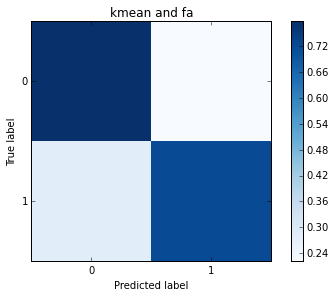

In [70]:
epi_prediction.plot_confusion_matrix(cv_combos_no_dmean.normalized_confusion_matrix(), "kmean and fa")

In [ ]:
# from joblib import Parallel, delayed

# def mask_list(row):
#     ret = []
#     count = 0
#     for l in row:
#         rrr = []
#         for f in l:

#             count += 1
#             if count % 5 == 0:
#                 print '{} files done'.format(count)
#                 print f

#         ret.append(rrr)
#     print 'row done'
#     return ret
# def mask_list_mcpu(l):
#     rrr = []
#     for f in l:
#         mask = create_mask(white_matter,nib.load(f))
#         maskd = mask.get_data()
#         curd = nib.load(f).get_data()
#         curd = np.multiply(curd,maskd)
#         rrr.append(nib.Nifti1Image(curd,eye(4)))
#         count += 1
#         if count % 5 == 0:
#             print '{} files done'.format(count)
#             print f
#     return rrr

# def mask_list_parallel(row):
#     x = Parallel(n_jobs=1,verbose=100)(
#             delayed(mask_list_mcpu)(
#                 r_i) 
#                 for r_i in row)
#     return x
# # parallel = False
# # if parallel:
# #     dfz = epi_paths.apply(lambda row : mask_list_parallel(row),0)
# # else:
# #     dfz = epi_paths.dax.apply(lambda row : mask_list(row),0)

# dfz = epi_paths.dax.apply(lambda row:mask_list_mcpu(row),0)